# Sevilleta Watershed

In [1]:
watershed = 'Sevilleta'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/19-Sevilleta'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,30), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-15,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Streamflow

In [4]:
# USGS 08379500 PECOS RIVER NEAR ANTON CHICO, NM
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=08379500&referred_module=sw&period=&begin_date=1988-01-01&end_date=2017-12-31',
                   header = 0,parse_dates = True,skiprows=28,sep = '\t',
                   infer_datetime_format = True)
data.head(2)

agency_cd   site_no    datetime 99966_00060_00003 99966_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  08379500  1988-01-01              33.0                    A

In [5]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['99966_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['PECOS_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep1 = copy.deepcopy(prep)

PECOS_Discharge
datetime                   
1988-01-01             33.0
1988-01-02             26.0
1988-01-03             24.0

In [6]:
# USGS 07208500 RAYADO CREEK NEAR CIMARRON, NM
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=07208500&referred_module=sw&period=&begin_date=1988-01-01&end_date=2017-12-03',
                   header = 0,parse_dates = True,skiprows=28,sep = '\t',
                   infer_datetime_format = True)

data.head(2)

agency_cd   site_no    datetime 99629_00060_00003 99629_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  07208500  1988-01-01              1.60                    A

In [7]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['99629_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['RAYADO_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep2 = copy.deepcopy(prep)

RAYADO_Discharge
datetime                    
1988-01-01               1.6
1988-01-02               1.6
1988-01-03               1.6

In [8]:
prep = pd.concat([prep1,prep2],axis = 1,sort = True)
prep.head()

PECOS_Discharge  RAYADO_Discharge
1988-01-01             33.0               1.6
1988-01-02             26.0               1.6
1988-01-03             24.0               1.6
1988-01-04             24.0               1.7
1988-01-05             29.0               1.7

PECOS_Discharge  RAYADO_Discharge
1988-01-01         934.4544          45.30688
1988-01-02         736.2368          45.30688
1988-01-03         679.6032          45.30688
1988-01-04         679.6032          48.13856
1988-01-05         821.1872          48.13856

<Figure size 432x288 with 0 Axes>

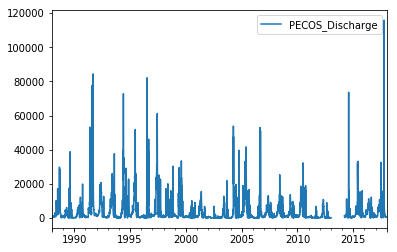

<Figure size 432x288 with 0 Axes>

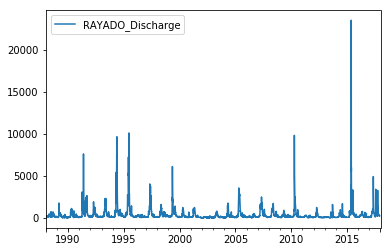

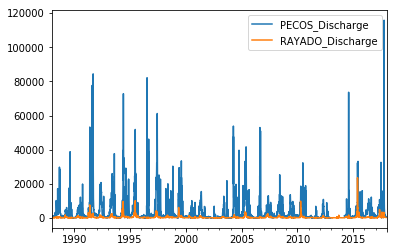

In [9]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]*28.3168
    
    plt.figure()
    df[[ready_columns[i]]].plot()
            
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head()

### Meteorology data

In [10]:
## many data are already gap filled data

In [11]:
### read the initial table

In [12]:
## data1 

In [13]:
data1 = pd.read_csv('https://sevlter.unm.edu/sites/default/files/data/sev1_meteorology_1988-1995_0.txt',header = 0,parse_dates = True,infer_datetime_format = True)
data1.head(3)

StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
0          1  1992           1     1  -1.926      -1.634      -2.215   
1          1  1992           1     2  -2.136      -1.905      -2.315   
2          1  1992           1     3  -2.415      -1.723      -2.845   

   Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  Vapor_Pressure  \
0               83.6           1.003           0.973  ...           4.432   
1               86.7           1.180           1.012  ...           4.527   
2               84.1           0.938           0.285  ...           4.305   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0            0.0           0.263           0.245            0.002   
1            0.0           0.264           0.245            0.000   
2            0.0           0.265           0.246            0.000   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                0.041                  0.0       -888.0   
1                0.041                  0.0       -888.0   
2                0.041                  0.0       -888.0   

   Evap_Pan_Temperature  Bar_Pressure  
0                -888.0        -888.0  
1                -888.0        -888.0  
2                -888.0        -888.0  

[3 rows x 26 columns]

In [14]:
data = copy.deepcopy(data1)

idlst = data['StationID'].unique()
dic = {}
for i in idlst:
    print(i)
    station_name = 'Station'+ str(i)
    dic[station_name] = data[data['StationID'] == i] 
    
    k = list(zip(dic[station_name]['Year'] , dic[station_name]['Julian_Day']))
    k = [str(x) for x in k]
    k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
    k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
    dic[station_name].index = k
    dic[station_name].index.rename('DateTime', inplace = True)
    
    display(dic[station_name].head(1))

1


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1992-1-1          1  1992           1     1  -1.926      -1.634      -2.215   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1992-1-1               83.6           1.003           0.973  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1992-1-1           4.432            0.0           0.263           0.245   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1992-1-1            0.002                0.041                  0.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1992-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

40


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1988-1-1         40  1988           1     1   -8.83      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1988-1-1               76.5           2.106           2.088  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1988-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1988-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1988-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

41


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         41  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

42


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         42  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

43


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         43  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

44


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         44  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

45


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         45  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

46


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         46  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

47


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1991-1-1         47  1991           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1991-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1991-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1991-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1991-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

In [15]:
## data2

In [16]:
data2 = pd.read_csv('https://sevlter.unm.edu/sites/default/files/data/sev1_meteorology_1996-2000_1.txt',header = 0,parse_dates = True,infer_datetime_format = True)
data2.head(3)

StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
0          1  1996           1     1   1.110       2.339       0.356   
1          1  1996           1     2   0.316       0.547       0.203   
2          1  1996           1     3   0.473       0.599       0.318   

   Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  Vapor_Pressure  \
0               96.6           1.867           1.746  ...           6.396   
1               99.6           1.965           1.155  ...           6.226   
2               99.5           2.671           2.565  ...           6.287   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0          0.551          -999.0          -999.0           -0.002   
1          0.000          -999.0          -999.0            0.000   
2          0.000          -999.0          -999.0           -0.003   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                0.041               -0.083        0.008   
1                0.083               -0.041       -0.725   
2                0.083               -0.083       -0.017   

   Evap_Pan_Temperature  Bar_Pressure  
0                 4.532        1010.0  
1                 4.326        1011.0  
2                 3.986        1011.0  

[3 rows x 26 columns]

In [17]:
data = copy.deepcopy(data2)

idlst = data['StationID'].unique()
# dic = {}
for i in idlst:
    print(i)
    station_name = 'Station'+ str(i)
        
    if station_name in dic.keys():
        tail_df = data[data['StationID'] == i] 

        k = list(zip(tail_df['Year'] , tail_df['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        tail_df.index = k
        tail_df.index.rename('DateTime', inplace = True)
        dic[station_name] = pd.concat([dic[station_name], tail_df], axis=0)
        display(dic[station_name].head(1))
    
    else:
        
        print('a new station')
        dic[station_name] = data[data['StationID'] == i] 

        k = list(zip(dic[station_name]['Year'] , dic[station_name]['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        dic[station_name].index = k
        dic[station_name].index.rename('DateTime', inplace = True)
        display(dic[station_name].head(1))

1


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1992-1-1          1  1992           1     1  -1.926      -1.634      -2.215   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1992-1-1               83.6           1.003           0.973  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1992-1-1           4.432            0.0           0.263           0.245   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1992-1-1            0.002                0.041                  0.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1992-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

40


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1988-1-1         40  1988           1     1   -8.83      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1988-1-1               76.5           2.106           2.088  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1988-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1988-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1988-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

41


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         41  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

42


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         42  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

43


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         43  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

44


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         44  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

45


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         45  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

46


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         46  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

47


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1991-1-1         47  1991           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1991-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1991-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1991-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1991-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

48
a new station


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1998-1-1         48  1998           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1998-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1998-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1998-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1998-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

49
a new station


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1999-1-1         49  1999           1     1     7.3        7.66         6.7   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1999-1-1             -888.0          -888.0          -888.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1999-1-1          -888.0            0.0          -888.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1999-1-1           -888.0               -888.0               -888.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1999-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

In [18]:
## data3

In [19]:
data3 = pd.read_csv('https://sevlter.unm.edu/sites/default/files/data/sev1_meteorology_2001-2005.txt',header = None,parse_dates = True,infer_datetime_format = True)
data3.head(3)

0     1   2   3      4      5      6     7      8      9   ...     16   17  \
0   1  2001   1   1 -3.446 -2.601 -4.464  90.4  1.043  0.587  ...  4.282  0.0   
1   1  2001   1   2 -4.993 -4.113 -5.493  95.6  0.502  0.129  ...  4.034  0.0   
2   1  2001   1   3 -4.707 -4.389 -5.280  94.6  0.230  0.124  ...  4.077  0.0   

      18     19     20    21    22   23   24     25  
0  0.409  0.366  0.000  0.08 -0.08  0.0  0.0  994.0  
1  0.411  0.367 -0.003  0.04 -0.08  0.0  0.0  994.0  
2  0.413  0.368 -0.002  0.04 -0.08  0.0  0.0  995.0  

[3 rows x 26 columns]

In [20]:
data3.columns = data1.columns
data3.head(2)

StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
0          1  2001           1     1  -3.446      -2.601      -4.464   
1          1  2001           1     2  -4.993      -4.113      -5.493   

   Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  Vapor_Pressure  \
0               90.4           1.043           0.587  ...           4.282   
1               95.6           0.502           0.129  ...           4.034   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0            0.0           0.409           0.366            0.000   
1            0.0           0.411           0.367           -0.003   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                 0.08                -0.08          0.0   
1                 0.04                -0.08          0.0   

   Evap_Pan_Temperature  Bar_Pressure  
0                   0.0         994.0  
1                   0.0         994.0  

[2 rows x 26 columns]

In [21]:
data = copy.deepcopy(data3)

idlst = data['StationID'].unique()
# dic = {}
for i in idlst:
    print(i)
    station_name = 'Station'+ str(i)
        
    if station_name in dic.keys():
        tail_df = data[data['StationID'] == i] 

        k = list(zip(tail_df['Year'] , tail_df['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        tail_df.index = k
        tail_df.index.rename('DateTime', inplace = True)
        dic[station_name] = pd.concat([dic[station_name], tail_df], axis=0)
        display(dic[station_name].head(1))
    
    else:
        
        print('a new station')
        dic[station_name] = data[data['StationID'] == i] 

        k = list(zip(dic[station_name]['Year'] , dic[station_name]['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        dic[station_name].index = k
        dic[station_name].index.rename('DateTime', inplace = True)
        display(dic[station_name].head(1))

1


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1992-1-1          1  1992           1     1  -1.926      -1.634      -2.215   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1992-1-1               83.6           1.003           0.973  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1992-1-1           4.432            0.0           0.263           0.245   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1992-1-1            0.002                0.041                  0.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1992-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

40


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1988-1-1         40  1988           1     1   -8.83      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1988-1-1               76.5           2.106           2.088  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1988-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1988-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1988-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

41


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         41  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

42


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         42  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

43


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         43  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

44


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         44  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

45


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         45  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

48


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1998-1-1         48  1998           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1998-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1998-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1998-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1998-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

49


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1999-1-1         49  1999           1     1     7.3        7.66         6.7   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1999-1-1             -888.0          -888.0          -888.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1999-1-1          -888.0            0.0          -888.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1999-1-1           -888.0               -888.0               -888.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1999-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

50
a new station


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
2002-1-1         50  2002           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
2002-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
2002-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
2002-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
2002-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

In [22]:
## data4

In [23]:
data4 = pd.read_csv('https://sevlter.unm.edu/sites/default/files/data/sev1_meteorology_2006-2010.txt',header = 0,parse_dates = True,infer_datetime_format = True)
data4.head(3)


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
0          1  2006           1     1   12.18       12.72       11.34   
1          1  2006           1     2   12.77       12.98       12.30   
2          1  2006           1     3   11.66       12.23       10.99   

   Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  Vapor_Pressure  \
0              29.28           5.349           5.213  ...           4.150   
1              29.05           9.180           9.020  ...           4.282   
2              31.95           8.370           8.220  ...           4.375   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0            0.0          -999.0          -999.0            0.036   
1            0.0          -999.0          -999.0            0.035   
2            0.0          -999.0          -999.0            0.032   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                0.080                -0.04          0.0   
1                0.119                -0.04          0.0   
2                0.119                -0.04          0.0   

   Evap_Pan_Temperature  Bar_Pressure  
0                   0.0         987.0  
1                   0.0         987.0  
2                   0.0         987.0  

[3 rows x 26 columns]

In [24]:
data = copy.deepcopy(data4)

idlst = data['StationID'].unique()
# dic = {}
for i in idlst:
    print(i)
    station_name = 'Station'+ str(i)
        
    if station_name in dic.keys():
        tail_df = data[data['StationID'] == i] 

        k = list(zip(tail_df['Year'] , tail_df['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        tail_df.index = k
        tail_df.index.rename('DateTime', inplace = True)
        dic[station_name] = pd.concat([dic[station_name], tail_df], axis=0)
        display(dic[station_name].head(1))
    
    else:
        
        print('a new station')
        dic[station_name] = data[data['StationID'] == i] 

        k = list(zip(dic[station_name]['Year'] , dic[station_name]['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        dic[station_name].index = k
        dic[station_name].index.rename('DateTime', inplace = True)
        display(dic[station_name].head(1))

1


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1992-1-1          1  1992           1     1  -1.926      -1.634      -2.215   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1992-1-1               83.6           1.003           0.973  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1992-1-1           4.432            0.0           0.263           0.245   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1992-1-1            0.002                0.041                  0.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1992-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

40


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1988-1-1         40  1988           1     1   -8.83      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1988-1-1               76.5           2.106           2.088  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1988-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1988-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1988-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

41


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         41  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

42


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         42  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

43


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         43  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

44


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         44  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

45


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         45  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

48


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1998-1-1         48  1998           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1998-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1998-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1998-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1998-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

49


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1999-1-1         49  1999           1     1     7.3        7.66         6.7   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1999-1-1             -888.0          -888.0          -888.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1999-1-1          -888.0            0.0          -888.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1999-1-1           -888.0               -888.0               -888.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1999-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

50


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
2002-1-1         50  2002           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
2002-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
2002-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
2002-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
2002-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

In [25]:
## data5

In [26]:
data5 = pd.read_csv('https://sevlter.unm.edu/sites/default/files/data/sev1_meteorology_2011-2015.txt',header = 0,parse_dates = True,infer_datetime_format = True)
data5.head(3)

RecordID  StationID  Year  Julian_Day   Hour  Temp_C  Max_Temp_C  \
0         1       2011     1           1  -8.57   -8.29       -8.96   
1         1       2011     1           2  -8.98   -8.62       -9.30   
2         1       2011     1           3 -10.01   -8.83      -11.05   

   Min_Temp_C  Relative_Humidity  Mean_WindSpeed  ...  Vapor_Pressure  \
0       43.99              6.115           6.046  ...             0.0   
1       44.52              3.424           2.854  ...             0.0   
2       48.30              1.708           1.040  ...             0.0   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0         -999.0          -999.0           0.024            0.134   
1         -999.0          -999.0           0.034            0.134   
2         -999.0          -999.0           0.028            0.134   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                0.000               -888.0      -6999.0   
1               -0.067               -888.0      -6999.0   
2                0.000               -888.0      -6999.0   

   Evap_Pan_Temperature  Bar_Pressure  
0                6999.0           NaN  
1                6999.0           NaN  
2                6999.0           NaN  

[3 rows x 27 columns]

In [27]:
column_name = data5.columns[1:]
data5.drop(columns = 'Bar_Pressure',inplace = True)
data5.columns = column_name
data5.head(2)

StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
0          1  2011           1     1   -8.57       -8.29       -8.96   
1          1  2011           1     2   -8.98       -8.62       -9.30   

   Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  Vapor_Pressure  \
0              43.99           6.115           6.046  ...           1.409   
1              44.52           3.424           2.854  ...           1.381   

   Precipitation  Moisture_10_cm  Moisture_30_cm  Solar_Radiation  \
0            0.0          -999.0          -999.0            0.024   
1            0.0          -999.0          -999.0            0.034   

   Max_Solar_Radiation  Min_Solar_Radiation  Evaporation  \
0                0.134                0.000       -888.0   
1                0.134               -0.067       -888.0   

   Evap_Pan_Temperature  Bar_Pressure  
0               -6999.0        6999.0  
1               -6999.0        6999.0  

[2 rows x 26 columns]

In [28]:
data = copy.deepcopy(data5)

idlst = data['StationID'].unique()
# dic = {}
for i in idlst:
    print(i)
    station_name = 'Station'+ str(i)
        
    if station_name in dic.keys():
        tail_df = data[data['StationID'] == i] 

        k = list(zip(tail_df['Year'] , tail_df['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        tail_df.index = k
        tail_df.index.rename('DateTime', inplace = True)
        dic[station_name] = pd.concat([dic[station_name], tail_df], axis=0)
        display(dic[station_name].head(1))
    
    else:
        
        print('a new station')
        dic[station_name] = data[data['StationID'] == i] 

        k = list(zip(dic[station_name]['Year'] , dic[station_name]['Julian_Day']))
        k = [str(x) for x in k]
        k = [pd.datetime.strptime(x, '(%Y, %j)') for x in k]
        k = [str(x.year) +'-' + str(x.month) + '-' + str(x.day) for x in k]
        dic[station_name].index = k
        dic[station_name].index.rename('DateTime', inplace = True)
        display(dic[station_name].head(1))

1


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1992-1-1          1  1992           1     1  -1.926      -1.634      -2.215   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1992-1-1               83.6           1.003           0.973  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1992-1-1           4.432            0.0           0.263           0.245   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1992-1-1            0.002                0.041                  0.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1992-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

40


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1988-1-1         40  1988           1     1   -8.83      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1988-1-1               76.5           2.106           2.088  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1988-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1988-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1988-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

41


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         41  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

42


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         42  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

43


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         43  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

44


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1989-1-1         44  1989           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1989-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1989-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1989-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1989-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

45


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1990-1-1         45  1990           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1990-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1990-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1990-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1990-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

48


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1998-1-1         48  1998           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1998-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1998-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1998-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1998-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

49


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
1999-1-1         49  1999           1     1     7.3        7.66         6.7   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
1999-1-1             -888.0          -888.0          -888.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
1999-1-1          -888.0            0.0          -888.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
1999-1-1           -888.0               -888.0               -888.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
1999-1-1       -888.0                -888.0        -888.0  

[1 rows x 26 columns]

50


StationID  Year  Julian_Day  Hour  Temp_C  Max_Temp_C  Min_Temp_C  \
DateTime                                                                      
2002-1-1         50  2002           1     1  -999.0      -999.0      -999.0   

          Relative_Humidity  Mean_WindSpeed  Vect_WindSpeed  ...  \
DateTime                                                     ...   
2002-1-1             -999.0          -999.0          -999.0  ...   

          Vapor_Pressure  Precipitation  Moisture_10_cm  Moisture_30_cm  \
DateTime                                                                  
2002-1-1          -999.0         -999.0          -999.0          -999.0   

          Solar_Radiation  Max_Solar_Radiation  Min_Solar_Radiation  \
DateTime                                                              
2002-1-1           -999.0               -999.0               -999.0   

          Evaporation  Evap_Pan_Temperature  Bar_Pressure  
DateTime                                                   
2002-1-1       -999.0                -999.0        -999.0  

[1 rows x 26 columns]

### 2. Precipitation

In [29]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Precipitation']]
    prep1.columns = [key + '_Precipitation']
    
    prep1= threC(prep1,'Precipitation')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).sum()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_Precipitation
DateTime                          
1992-01-01                     0.0
1992-01-02                     0.0
1992-01-03                     0.0

Station1_Precipitation  Station40_Precipitation
DateTime                                                   
1988-01-01                     NaN                      0.0
1988-01-02                     NaN                      0.0
1988-01-03                     NaN                      0.0

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_Precipitation  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_Precipitation  Station48_Precipitation  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_Precipitation  Station48_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_Precipitation  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   
1988-01-03                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_Precipitation  Station48_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_Precipitation  Station50_Precipitation  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_Precipitation  Station40_Precipitation  \
DateTime                                                      
2015-12-30                   2.752                    0.000   
2015-12-31                   3.028                    0.102   

            Station41_Precipitation  Station42_Precipitation  \
DateTime                                                       
2015-12-30                    2.887                    0.000   
2015-12-31                    0.000                    0.104   

            Station43_Precipitation  Station44_Precipitation  \
DateTime                                                       
2015-12-30                      0.0                      0.5   
2015-12-31                      0.0                      3.0   

            Station45_Precipitation  Station46_Precipitation  \
DateTime                                                       
2015-12-30                    1.124                      NaN   
2015-12-31                    1.124                      NaN   

            Station47_Precipitation  Station48_Precipitation  \
DateTime                                                       
2015-12-30                      NaN                      0.0   
2015-12-31                      NaN                      0.0   

            Station49_Precipitation  Station50_Precipitation  
DateTime                                                      
2015-12-30                    0.000                      0.0  
2015-12-31                    0.106                      0.0

Station1_Precipitation
Station40_Precipitation
Station41_Precipitation
Station42_Precipitation
Station43_Precipitation
Station44_Precipitation
Station45_Precipitation
Station46_Precipitation
Station47_Precipitation
Station48_Precipitation
Station49_Precipitation
Station50_Precipitation


Station1_Precipitation  Station40_Precipitation  \
1988-01-01                     NaN                      0.0   
1988-01-02                     NaN                      0.0   

            Station41_Precipitation  Station42_Precipitation  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station43_Precipitation  Station44_Precipitation  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station45_Precipitation  Station46_Precipitation  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station47_Precipitation  Station48_Precipitation  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station49_Precipitation  Station50_Precipitation  
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN

<Figure size 720x288 with 0 Axes>

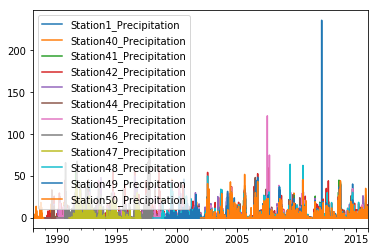

In [30]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
Precipitation = copy.deepcopy(df)
Precipitation.plot()
Precipitation.head(2)

### 3. AirTemperature

In [31]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Temp_C']]
    prep1.columns = [key + '_AirTemperature']
    
    prep1= threC(prep1,'AirTemperature')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_AirTemperature
DateTime                           
1992-01-01                -0.088125
1992-01-02                -1.408583
1992-01-03                -2.965583

Station1_AirTemperature  Station40_AirTemperature
DateTime                                                     
1988-01-01                      NaN                 -6.163333
1988-01-02                      NaN                 -5.683333
1988-01-03                      NaN                 -4.202917

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_AirTemperature  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_AirTemperature  Station48_AirTemperature  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_AirTemperature  Station48_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station49_AirTemperature  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   
1988-01-03                      NaN                 -4.202917   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_AirTemperature  Station48_AirTemperature  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station49_AirTemperature  Station50_AirTemperature  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_AirTemperature  Station40_AirTemperature  \
DateTime                                                        
2015-12-30                -7.021958                 -6.942958   
2015-12-31                -5.131708                 -6.537958   

            Station41_AirTemperature  Station42_AirTemperature  \
DateTime                                                         
2015-12-30                 -9.324583                  -3.06750   
2015-12-31                 -6.658667                  -3.27575   

            Station43_AirTemperature  Station44_AirTemperature  \
DateTime                                                         
2015-12-30                 -2.603250                 -4.915167   
2015-12-31                 -3.861083                 -4.912708   

            Station45_AirTemperature  Station46_AirTemperature  \
DateTime                                                         
2015-12-30                 -6.270750                       NaN   
2015-12-31                 -4.988208                       NaN   

            Station47_AirTemperature  Station48_AirTemperature  \
DateTime                                                         
2015-12-30                       NaN                 -4.536375   
2015-12-31                       NaN                 -4.086708   

            Station49_AirTemperature  Station50_AirTemperature  
DateTime                                                        
2015-12-30                 -4.138083                 -1.440208  
2015-12-31                 -5.289583                 -2.941833

Station1_AirTemperature
Station40_AirTemperature
Station41_AirTemperature
Station42_AirTemperature
Station43_AirTemperature
Station44_AirTemperature
Station45_AirTemperature
Station46_AirTemperature
Station47_AirTemperature
Station48_AirTemperature
Station49_AirTemperature
Station50_AirTemperature


Station1_AirTemperature  Station40_AirTemperature  \
1988-01-01                      NaN                 -6.163333   
1988-01-02                      NaN                 -5.683333   

            Station41_AirTemperature  Station42_AirTemperature  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station43_AirTemperature  Station44_AirTemperature  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station45_AirTemperature  Station46_AirTemperature  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station47_AirTemperature  Station48_AirTemperature  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station49_AirTemperature  Station50_AirTemperature  
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN

<Figure size 720x288 with 0 Axes>

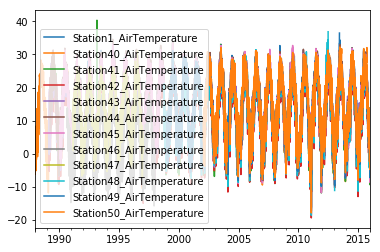

In [32]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head(2)

### 4. SolarRadiation

In [33]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Solar_Radiation']]
    prep1.columns = [key + '_SolarRadiation']
    
    prep1= threC(prep1,'SolarRadiation')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).sum()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_SolarRadiation
DateTime                           
1992-01-01                 1257.951
1992-01-02                 1300.626
1992-01-03                  301.027

Station1_SolarRadiation  Station40_SolarRadiation
DateTime                                                     
1988-01-01                      NaN                       0.0
1988-01-02                      NaN                       0.0
1988-01-03                      NaN                       0.0

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_SolarRadiation  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_SolarRadiation  Station48_SolarRadiation  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_SolarRadiation  Station48_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station49_SolarRadiation  
DateTime                              
1988-01-01                       NaN  
1988-01-02                       NaN  
1988-01-03                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   
1988-01-03                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station47_SolarRadiation  Station48_SolarRadiation  \
DateTime                                                         
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   
1988-01-03                       NaN                       NaN   

            Station49_SolarRadiation  Station50_SolarRadiation  
DateTime                                                        
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN  
1988-01-03                       NaN                       NaN

Station1_SolarRadiation  Station40_SolarRadiation  \
DateTime                                                        
2015-12-30                 1217.219                  1295.334   
2015-12-31                 1104.671                  1160.104   

            Station41_SolarRadiation  Station42_SolarRadiation  \
DateTime                                                         
2015-12-30                  1363.653                  1380.268   
2015-12-31                  1275.367                  1279.350   

            Station43_SolarRadiation  Station44_SolarRadiation  \
DateTime                                                         
2015-12-30                  1477.663                  1486.268   
2015-12-31                  1353.498                  1357.493   

            Station45_SolarRadiation  Station46_SolarRadiation  \
DateTime                                                         
2015-12-30                  1225.811                       NaN   
2015-12-31                  1159.753                       NaN   

            Station47_SolarRadiation  Station48_SolarRadiation  \
DateTime                                                         
2015-12-30                       NaN                  1394.159   
2015-12-31                       NaN                  1286.798   

            Station49_SolarRadiation  Station50_SolarRadiation  
DateTime                                                        
2015-12-30                       0.0                  1489.020  
2015-12-31                       0.0                  1382.519

Station1_SolarRadiation
Station40_SolarRadiation
Station41_SolarRadiation
Station42_SolarRadiation
Station43_SolarRadiation
Station44_SolarRadiation
Station45_SolarRadiation
Station46_SolarRadiation
Station47_SolarRadiation
Station48_SolarRadiation
Station49_SolarRadiation
Station50_SolarRadiation


Station1_SolarRadiation  Station40_SolarRadiation  \
1988-01-01                      NaN                       0.0   
1988-01-02                      NaN                       0.0   

            Station41_SolarRadiation  Station42_SolarRadiation  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station43_SolarRadiation  Station44_SolarRadiation  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station45_SolarRadiation  Station46_SolarRadiation  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station47_SolarRadiation  Station48_SolarRadiation  \
1988-01-01                       NaN                       NaN   
1988-01-02                       NaN                       NaN   

            Station49_SolarRadiation  Station50_SolarRadiation  
1988-01-01                       NaN                       NaN  
1988-01-02                       NaN                       NaN

<Figure size 720x288 with 0 Axes>

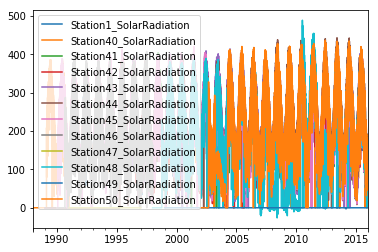

In [34]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]/8.64 # to W/m2 , 1/86400 J = 1 W/d, 1 m2 = 10000 cm2

SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head(2)

### 5. Relative Humidity

In [35]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Relative_Humidity']]
    prep1.columns = [key + '_RelativeHumidity']
    
    prep1= threC(prep1,'RelativeHumidity')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_RelativeHumidity
DateTime                             
1992-01-01                  72.432083
1992-01-02                  68.762500
1992-01-03                  80.881667

Station1_RelativeHumidity  Station40_RelativeHumidity
DateTime                                                         
1988-01-01                        NaN                   62.417917
1988-01-02                        NaN                   67.661667
1988-01-03                        NaN                   62.433333

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  
DateTime                                
1988-01-01                         NaN  
1988-01-02                         NaN  
1988-01-03                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  
DateTime                                                            
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN  
1988-01-03                         NaN                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  
DateTime                                
1988-01-01                         NaN  
1988-01-02                         NaN  
1988-01-03                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  
DateTime                                                            
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN  
1988-01-03                         NaN                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  
DateTime                                
1988-01-01                         NaN  
1988-01-02                         NaN  
1988-01-03                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  
DateTime                                                            
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN  
1988-01-03                         NaN                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station47_RelativeHumidity  
DateTime                                
1988-01-01                         NaN  
1988-01-02                         NaN  
1988-01-03                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station47_RelativeHumidity  Station48_RelativeHumidity  
DateTime                                                            
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN  
1988-01-03                         NaN                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station47_RelativeHumidity  Station48_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station49_RelativeHumidity  
DateTime                                
1988-01-01                         NaN  
1988-01-02                         NaN  
1988-01-03                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   
1988-01-03                        NaN                   62.433333   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station47_RelativeHumidity  Station48_RelativeHumidity  \
DateTime                                                             
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   
1988-01-03                         NaN                         NaN   

            Station49_RelativeHumidity  Station50_RelativeHumidity  
DateTime                                                            
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN  
1988-01-03                         NaN                         NaN

Station1_RelativeHumidity  Station40_RelativeHumidity  \
DateTime                                                            
2015-12-30                  81.977500                   80.499583   
2015-12-31                  77.802083                   81.541250   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
DateTime                                                             
2015-12-30                   79.742917                   64.380833   
2015-12-31                   78.495833                   74.695833   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
DateTime                                                             
2015-12-30                   65.978750                   79.771250   
2015-12-31                   73.955833                   75.783333   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
DateTime                                                             
2015-12-30                   80.466250                         NaN   
2015-12-31                   77.221667                         NaN   

            Station47_RelativeHumidity  Station48_RelativeHumidity  \
DateTime                                                             
2015-12-30                         NaN                   73.212500   
2015-12-31                         NaN                   75.220833   

            Station49_RelativeHumidity  Station50_RelativeHumidity  
DateTime                                                            
2015-12-30                   77.882500                    59.82750  
2015-12-31                   86.688333                    72.34875

Station1_RelativeHumidity
Station40_RelativeHumidity
Station41_RelativeHumidity
Station42_RelativeHumidity
Station43_RelativeHumidity
Station44_RelativeHumidity
Station45_RelativeHumidity
Station46_RelativeHumidity
Station47_RelativeHumidity
Station48_RelativeHumidity
Station49_RelativeHumidity
Station50_RelativeHumidity


Station1_RelativeHumidity  Station40_RelativeHumidity  \
1988-01-01                        NaN                   62.417917   
1988-01-02                        NaN                   67.661667   

            Station41_RelativeHumidity  Station42_RelativeHumidity  \
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   

            Station43_RelativeHumidity  Station44_RelativeHumidity  \
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   

            Station45_RelativeHumidity  Station46_RelativeHumidity  \
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   

            Station47_RelativeHumidity  Station48_RelativeHumidity  \
1988-01-01                         NaN                         NaN   
1988-01-02                         NaN                         NaN   

            Station49_RelativeHumidity  Station50_RelativeHumidity  
1988-01-01                         NaN                         NaN  
1988-01-02                         NaN                         NaN

<Figure size 720x288 with 0 Axes>

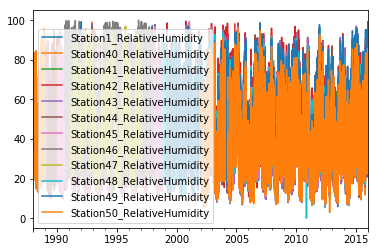

In [36]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head(2)

### 6. WindDirection

In [37]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Wind_Dir']]
    prep1.columns = [key + '_WindDirection']
    
    prep1= threC(prep1,'WindDirection')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_WindDirection
DateTime                          
1992-01-01              155.555000
1992-01-02              207.787083
1992-01-03              161.890417

Station1_WindDirection  Station40_WindDirection
DateTime                                                   
1988-01-01                     NaN                71.300000
1988-01-02                     NaN               133.445833
1988-01-03                     NaN               177.683333

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_WindDirection  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_WindDirection  Station48_WindDirection  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_WindDirection  Station48_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_WindDirection  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   
1988-01-03                     NaN               177.683333   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_WindDirection  Station48_WindDirection  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_WindDirection  Station50_WindDirection  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_WindDirection  Station40_WindDirection  \
DateTime                                                      
2015-12-30              223.898750               158.512500   
2015-12-31              186.165833               120.030417   

            Station41_WindDirection  Station42_WindDirection  \
DateTime                                                       
2015-12-30               101.078333               283.412500   
2015-12-31                70.741250               241.285833   

            Station43_WindDirection  Station44_WindDirection  \
DateTime                                                       
2015-12-30               249.154167               211.953333   
2015-12-31               183.545417               224.232083   

            Station45_WindDirection  Station46_WindDirection  \
DateTime                                                       
2015-12-30               235.423750                      NaN   
2015-12-31               191.077917                      NaN   

            Station47_WindDirection  Station48_WindDirection  \
DateTime                                                       
2015-12-30                      NaN               175.778750   
2015-12-31                      NaN               144.292917   

            Station49_WindDirection  Station50_WindDirection  
DateTime                                                      
2015-12-30               160.512500               158.481667  
2015-12-31                98.879167               151.601667

Station1_WindDirection
Station40_WindDirection
Station41_WindDirection
Station42_WindDirection
Station43_WindDirection
Station44_WindDirection
Station45_WindDirection
Station46_WindDirection
Station47_WindDirection
Station48_WindDirection
Station49_WindDirection
Station50_WindDirection


Station1_WindDirection  Station40_WindDirection  \
1988-01-01                     NaN                71.300000   
1988-01-02                     NaN               133.445833   

            Station41_WindDirection  Station42_WindDirection  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station43_WindDirection  Station44_WindDirection  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station45_WindDirection  Station46_WindDirection  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station47_WindDirection  Station48_WindDirection  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station49_WindDirection  Station50_WindDirection  
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN

<Figure size 720x288 with 0 Axes>

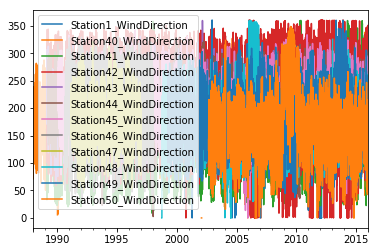

In [38]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)): 
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head(2)

### 7. WindSpeed

In [39]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Mean_WindSpeed']]
    prep1.columns = [key + '_WindSpeed']
    
    prep1= threC(prep1,'WindSpeed')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_WindSpeed
DateTime                      
1992-01-01            2.413667
1992-01-02            3.082083
1992-01-03            1.736167

Station1_WindSpeed  Station40_WindSpeed
DateTime                                           
1988-01-01                 NaN             2.874875
1988-01-02                 NaN             1.827708
1988-01-03                 NaN             1.891500

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed
DateTime                                                                
1988-01-01                 NaN             2.874875                  NaN
1988-01-02                 NaN             1.827708                  NaN
1988-01-03                 NaN             1.891500                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  
DateTime                         
1988-01-01                  NaN  
1988-01-02                  NaN  
1988-01-03                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  
DateTime                                              
1988-01-01                  NaN                  NaN  
1988-01-02                  NaN                  NaN  
1988-01-03                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  
DateTime                                                                   
1988-01-01                  NaN                  NaN                  NaN  
1988-01-02                  NaN                  NaN                  NaN  
1988-01-03                  NaN                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  
DateTime                         
1988-01-01                  NaN  
1988-01-02                  NaN  
1988-01-03                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  
DateTime                                              
1988-01-01                  NaN                  NaN  
1988-01-02                  NaN                  NaN  
1988-01-03                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  
DateTime                                                                   
1988-01-01                  NaN                  NaN                  NaN  
1988-01-02                  NaN                  NaN                  NaN  
1988-01-03                  NaN                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station48_WindSpeed  
DateTime                         
1988-01-01                  NaN  
1988-01-02                  NaN  
1988-01-03                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station48_WindSpeed  Station49_WindSpeed  
DateTime                                              
1988-01-01                  NaN                  NaN  
1988-01-02                  NaN                  NaN  
1988-01-03                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   
1988-01-03                 NaN             1.891500                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  \
DateTime                                                                    
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   
1988-01-03                  NaN                  NaN                  NaN   

            Station48_WindSpeed  Station49_WindSpeed  Station50_WindSpeed  
DateTime                                                                   
1988-01-01                  NaN                  NaN                  NaN  
1988-01-02                  NaN                  NaN                  NaN  
1988-01-03                  NaN                  NaN                  NaN

Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
DateTime                                                                   
2015-12-30            1.005500             2.232958             0.162167   
2015-12-31            1.300458             1.752333             1.942000   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
DateTime                                                                    
2015-12-30             1.926500             2.534708             2.084125   
2015-12-31             1.683708             2.020417             2.388167   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  \
DateTime                                                                    
2015-12-30             1.629500                  NaN                  NaN   
2015-12-31             2.230167                  NaN                  NaN   

            Station48_WindSpeed  Station49_WindSpeed  Station50_WindSpeed  
DateTime                                                                   
2015-12-30             1.013292             1.978542             2.036458  
2015-12-31             2.278625             1.379667             2.917042

Station1_WindSpeed
Station40_WindSpeed
Station41_WindSpeed
Station42_WindSpeed
Station43_WindSpeed
Station44_WindSpeed
Station45_WindSpeed
Station46_WindSpeed
Station47_WindSpeed
Station48_WindSpeed
Station49_WindSpeed
Station50_WindSpeed


Station1_WindSpeed  Station40_WindSpeed  Station41_WindSpeed  \
1988-01-01                 NaN             2.874875                  NaN   
1988-01-02                 NaN             1.827708                  NaN   

            Station42_WindSpeed  Station43_WindSpeed  Station44_WindSpeed  \
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   

            Station45_WindSpeed  Station46_WindSpeed  Station47_WindSpeed  \
1988-01-01                  NaN                  NaN                  NaN   
1988-01-02                  NaN                  NaN                  NaN   

            Station48_WindSpeed  Station49_WindSpeed  Station50_WindSpeed  
1988-01-01                  NaN                  NaN                  NaN  
1988-01-02                  NaN                  NaN                  NaN

<Figure size 720x288 with 0 Axes>

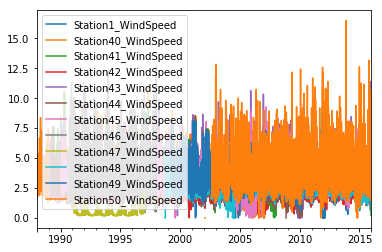

In [40]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

### 8. SWE

### 9. SnowDepth

### 10. VaporPressure

In [41]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Vapor_Pressure']]
    prep1.columns = [key + '_VaporPressure']
    
    prep1= threC(prep1,'VaporPressure')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_VaporPressure
DateTime                          
1992-01-01                4.312167
1992-01-02                3.706542
1992-01-03                3.958292

Station1_VaporPressure  Station40_VaporPressure
DateTime                                                   
1988-01-01                     NaN                      NaN
1988-01-02                     NaN                      NaN
1988-01-03                     NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_VaporPressure  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_VaporPressure  
DateTime                             
1988-01-01                      NaN  
1988-01-02                      NaN  
1988-01-03                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   
1988-01-03                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   

            Station49_VaporPressure  Station50_VaporPressure  
DateTime                                                      
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN  
1988-01-03                      NaN                      NaN

Station1_VaporPressure  Station40_VaporPressure  \
DateTime                                                      
2015-12-30                3.055792                 2.985625   
2015-12-31                3.306458                 3.187000   

            Station41_VaporPressure  Station42_VaporPressure  \
DateTime                                                       
2015-12-30                 2.578958                 3.067750   
2015-12-31                 3.065542                 3.492542   

            Station43_VaporPressure  Station44_VaporPressure  \
DateTime                                                       
2015-12-30                 3.309625                 3.387375   
2015-12-31                 3.354417                 3.289375   

            Station45_VaporPressure  Station46_VaporPressure  \
DateTime                                                       
2015-12-30                 3.105250                      NaN   
2015-12-31                 3.290708                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  \
DateTime                                                       
2015-12-30                      NaN                 3.152375   
2015-12-31                      NaN                 3.371292   

            Station49_VaporPressure  Station50_VaporPressure  
DateTime                                                      
2015-12-30                 3.456958                 3.180750  
2015-12-31                 3.601792                 3.492583

Station1_VaporPressure
Station40_VaporPressure
Station41_VaporPressure
Station42_VaporPressure
Station43_VaporPressure
Station44_VaporPressure
Station45_VaporPressure
Station46_VaporPressure
Station47_VaporPressure
Station48_VaporPressure
Station49_VaporPressure
Station50_VaporPressure


Station1_VaporPressure  Station40_VaporPressure  \
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station49_VaporPressure  Station50_VaporPressure  
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN

<Figure size 720x288 with 0 Axes>

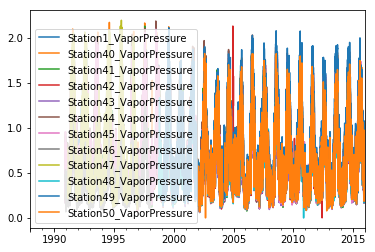

In [42]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] * 0.1# 
                       
VaporPressure = copy.deepcopy(df)
VaporPressure.plot()
VaporPressure.head(2)

### 11. SoilMoisture

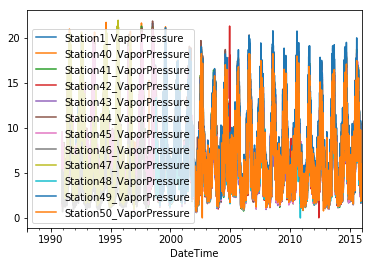

In [43]:
prep.plot()

Station1_VaporPressure
Station40_VaporPressure
Station41_VaporPressure
Station42_VaporPressure
Station43_VaporPressure
Station44_VaporPressure
Station45_VaporPressure
Station46_VaporPressure
Station47_VaporPressure
Station48_VaporPressure
Station49_VaporPressure
Station50_VaporPressure


Station1_VaporPressure  Station40_VaporPressure  \
1988-01-01                     NaN                      NaN   
1988-01-02                     NaN                      NaN   

            Station41_VaporPressure  Station42_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station43_VaporPressure  Station44_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station45_VaporPressure  Station46_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station47_VaporPressure  Station48_VaporPressure  \
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   

            Station49_VaporPressure  Station50_VaporPressure  
1988-01-01                      NaN                      NaN  
1988-01-02                      NaN                      NaN

<Figure size 720x288 with 0 Axes>

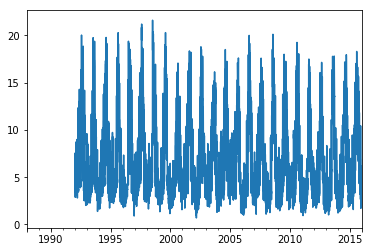

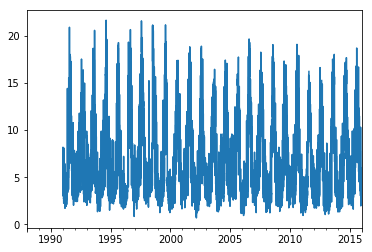

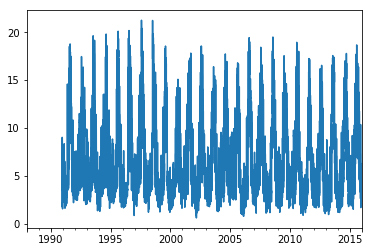

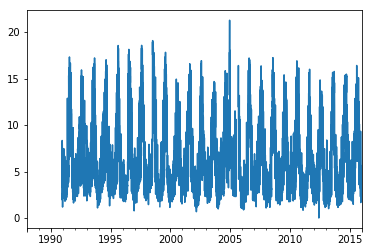

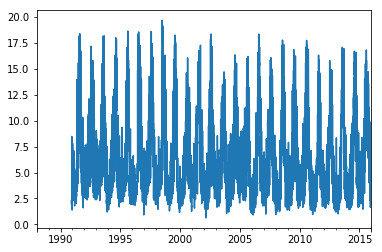

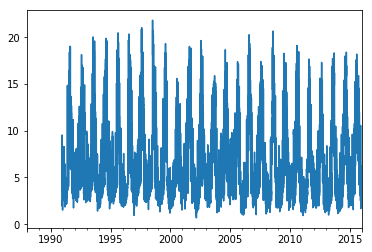

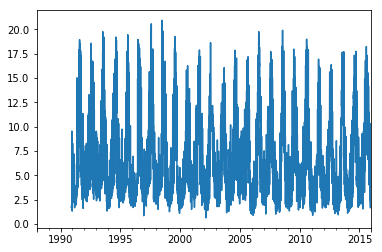

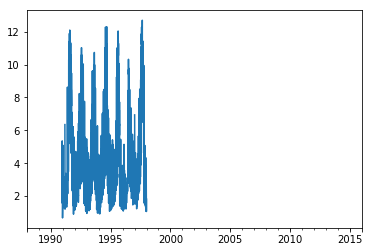

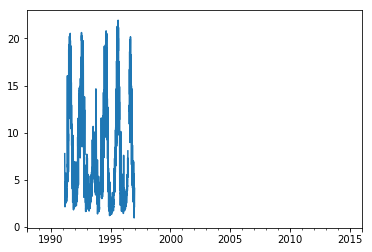

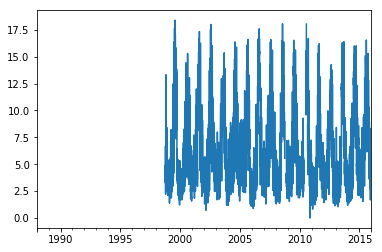

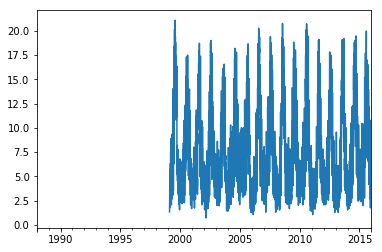

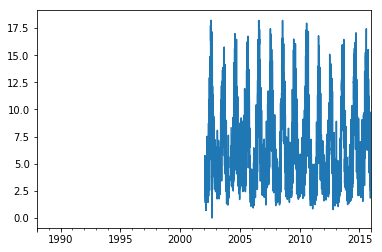

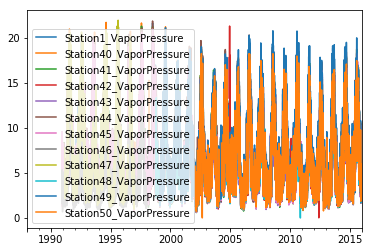

In [47]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
    plt.figure()
    df[site].plot()
    
SoilMoisture1 = copy.deepcopy(df)
SoilMoisture1.plot()
SoilMoisture1.head(2)

In [48]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Moisture_30_cm']]
    prep1.columns = [key + '_SoilMoisture_30cm']
    
    prep1= threC(prep1,'SoilMoisture')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_SoilMoisture_30cm
DateTime                              
1992-01-01                    0.251292
1992-01-02                    0.261333
1992-01-03                    0.271750

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm
DateTime                                                           
1988-01-01                         NaN                          NaN
1988-01-02                         NaN                          NaN
1988-01-03                         NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  
DateTime                                 
1988-01-01                          NaN  
1988-01-02                          NaN  
1988-01-03                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  
DateTime                                                              
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN  
1988-01-03                          NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  
DateTime                                 
1988-01-01                          NaN  
1988-01-02                          NaN  
1988-01-03                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  
DateTime                                                              
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN  
1988-01-03                          NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  
DateTime                                 
1988-01-01                          NaN  
1988-01-02                          NaN  
1988-01-03                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  
DateTime                                                              
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN  
1988-01-03                          NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station47_SoilMoisture_30cm  
DateTime                                 
1988-01-01                          NaN  
1988-01-02                          NaN  
1988-01-03                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station47_SoilMoisture_30cm  Station48_SoilMoisture_30cm  
DateTime                                                              
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN  
1988-01-03                          NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station47_SoilMoisture_30cm  Station48_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station49_SoilMoisture_30cm  
DateTime                                 
1988-01-01                          NaN  
1988-01-02                          NaN  
1988-01-03                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   
1988-01-03                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station47_SoilMoisture_30cm  Station48_SoilMoisture_30cm  \
DateTime                                                               
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   
1988-01-03                          NaN                          NaN   

            Station49_SoilMoisture_30cm  Station50_SoilMoisture_30cm  
DateTime                                                              
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN  
1988-01-03                          NaN                          NaN

Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
DateTime                                                              
2015-12-30                         NaN                     0.079917   
2015-12-31                         NaN                     0.079708   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
DateTime                                                               
2015-12-30                          NaN                          NaN   
2015-12-31                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
DateTime                                                               
2015-12-30                          NaN                          NaN   
2015-12-31                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
DateTime                                                               
2015-12-30                          NaN                          NaN   
2015-12-31                          NaN                          NaN   

            Station47_SoilMoisture_30cm  Station48_SoilMoisture_30cm  \
DateTime                                                               
2015-12-30                          NaN                      0.38375   
2015-12-31                          NaN                      0.42900   

            Station49_SoilMoisture_30cm  Station50_SoilMoisture_30cm  
DateTime                                                              
2015-12-30                     2.263429                          NaN  
2015-12-31                     2.212000                          NaN

Station1_SoilMoisture_30cm
Station40_SoilMoisture_30cm
Station41_SoilMoisture_30cm
Station42_SoilMoisture_30cm
Station43_SoilMoisture_30cm
Station44_SoilMoisture_30cm
Station45_SoilMoisture_30cm
Station46_SoilMoisture_30cm
Station47_SoilMoisture_30cm
Station48_SoilMoisture_30cm
Station49_SoilMoisture_30cm
Station50_SoilMoisture_30cm


Station1_SoilMoisture_30cm  Station40_SoilMoisture_30cm  \
1988-01-01                         NaN                          NaN   
1988-01-02                         NaN                          NaN   

            Station41_SoilMoisture_30cm  Station42_SoilMoisture_30cm  \
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   

            Station43_SoilMoisture_30cm  Station44_SoilMoisture_30cm  \
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   

            Station45_SoilMoisture_30cm  Station46_SoilMoisture_30cm  \
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   

            Station47_SoilMoisture_30cm  Station48_SoilMoisture_30cm  \
1988-01-01                          NaN                          NaN   
1988-01-02                          NaN                          NaN   

            Station49_SoilMoisture_30cm  Station50_SoilMoisture_30cm  
1988-01-01                          NaN                          NaN  
1988-01-02                          NaN                          NaN

<Figure size 720x288 with 0 Axes>

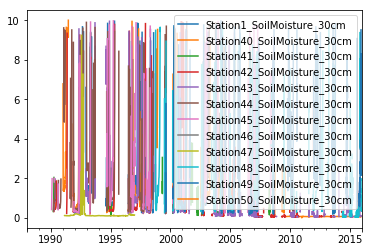

In [49]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SoilMoisture2 = copy.deepcopy(df)
SoilMoisture2.plot()
SoilMoisture2.head(2)

### 12. SoilTemperature

In [50]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Temp_1_cm']]
    prep1.columns = [key + '_SoilTemperature_1cm']
    
    prep1= threC(prep1,'SoilTemperature')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_SoilTemperature_1cm
DateTime                                
1992-01-01                      2.055417
1992-01-02                      0.999708
1992-01-03                     -0.610125

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm
DateTime                                                               
1988-01-01                           NaN                      -2.827083
1988-01-02                           NaN                      -2.141250
1988-01-03                           NaN                      -1.995833

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  
DateTime                                   
1988-01-01                            NaN  
1988-01-02                            NaN  
1988-01-03                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  
DateTime                                                                  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN  
1988-01-03                            NaN                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  
DateTime                                   
1988-01-01                            NaN  
1988-01-02                            NaN  
1988-01-03                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  
DateTime                                                                  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN  
1988-01-03                            NaN                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  
DateTime                                   
1988-01-01                            NaN  
1988-01-02                            NaN  
1988-01-03                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  
DateTime                                                                  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN  
1988-01-03                            NaN                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station47_SoilTemperature_1cm  
DateTime                                   
1988-01-01                            NaN  
1988-01-02                            NaN  
1988-01-03                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station47_SoilTemperature_1cm  Station48_SoilTemperature_1cm  
DateTime                                                                  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN  
1988-01-03                            NaN                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station47_SoilTemperature_1cm  Station48_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station49_SoilTemperature_1cm  
DateTime                                   
1988-01-01                            NaN  
1988-01-02                            NaN  
1988-01-03                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   
1988-01-03                           NaN                      -1.995833   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station47_SoilTemperature_1cm  Station48_SoilTemperature_1cm  \
DateTime                                                                   
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   
1988-01-03                            NaN                            NaN   

            Station49_SoilTemperature_1cm  Station50_SoilTemperature_1cm  
DateTime                                                                  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN  
1988-01-03                            NaN                            NaN

Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
DateTime                                                                  
2015-12-30                     -0.541042                       0.482542   
2015-12-31                     -1.043833                       0.231792   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
DateTime                                                                   
2015-12-30                       0.020125                      -0.754583   
2015-12-31                      -0.722292                      -0.742042   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
DateTime                                                                   
2015-12-30                      -0.102083                       0.197958   
2015-12-31                      -0.440500                       0.071875   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
DateTime                                                                   
2015-12-30                      -0.181042                            NaN   
2015-12-31                      -0.832375                            NaN   

            Station47_SoilTemperature_1cm  Station48_SoilTemperature_1cm  \
DateTime                                                                   
2015-12-30                            NaN                       1.630625   
2015-12-31                            NaN                       1.282750   

            Station49_SoilTemperature_1cm  Station50_SoilTemperature_1cm  
DateTime                                                                  
2015-12-30                       0.891458                      -0.407875  
2015-12-31                       0.719792                      -0.708875

Station1_SoilTemperature_1cm
Station40_SoilTemperature_1cm
Station41_SoilTemperature_1cm
Station42_SoilTemperature_1cm
Station43_SoilTemperature_1cm
Station44_SoilTemperature_1cm
Station45_SoilTemperature_1cm
Station46_SoilTemperature_1cm
Station47_SoilTemperature_1cm
Station48_SoilTemperature_1cm
Station49_SoilTemperature_1cm
Station50_SoilTemperature_1cm


Station1_SoilTemperature_1cm  Station40_SoilTemperature_1cm  \
1988-01-01                           NaN                      -2.827083   
1988-01-02                           NaN                      -2.141250   

            Station41_SoilTemperature_1cm  Station42_SoilTemperature_1cm  \
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   

            Station43_SoilTemperature_1cm  Station44_SoilTemperature_1cm  \
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   

            Station45_SoilTemperature_1cm  Station46_SoilTemperature_1cm  \
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   

            Station47_SoilTemperature_1cm  Station48_SoilTemperature_1cm  \
1988-01-01                            NaN                            NaN   
1988-01-02                            NaN                            NaN   

            Station49_SoilTemperature_1cm  Station50_SoilTemperature_1cm  
1988-01-01                            NaN                            NaN  
1988-01-02                            NaN                            NaN

<Figure size 720x288 with 0 Axes>

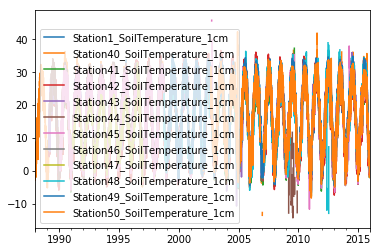

In [51]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SoilTemperature1 = copy.deepcopy(df)
SoilTemperature1.plot()
SoilTemperature1.head(2)

In [52]:
prep = pd.DataFrame()
for key in dic.keys():
    prep1 = dic[key][['Temp_10_cm']]
    prep1.columns = [key + '_SoilTemperature_10cm']
    
    prep1= threC(prep1,'SoilTemperature')
    prep1.index = pd.to_datetime(prep1.index)
    prep1 = prep1.groupby(prep1.index).mean()
    
    prep = pd.concat([prep, prep1], axis=1)
    display(prep.head(3))
prep.tail(2)

Station1_SoilTemperature_10cm
DateTime                                 
1992-01-01                       3.482083
1992-01-02                       2.660958
1992-01-03                       1.337958

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm
DateTime                                                                 
1988-01-01                            NaN                       -1.589583
1988-01-02                            NaN                       -1.211250
1988-01-03                            NaN                       -1.811250

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  
DateTime                                    
1988-01-01                             NaN  
1988-01-02                             NaN  
1988-01-03                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  
DateTime                                                                    
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN  
1988-01-03                             NaN                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  
DateTime                                    
1988-01-01                             NaN  
1988-01-02                             NaN  
1988-01-03                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  
DateTime                                                                    
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN  
1988-01-03                             NaN                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  
DateTime                                    
1988-01-01                             NaN  
1988-01-02                             NaN  
1988-01-03                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  
DateTime                                                                    
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN  
1988-01-03                             NaN                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station47_SoilTemperature_10cm  
DateTime                                    
1988-01-01                             NaN  
1988-01-02                             NaN  
1988-01-03                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station47_SoilTemperature_10cm  Station48_SoilTemperature_10cm  
DateTime                                                                    
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN  
1988-01-03                             NaN                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station47_SoilTemperature_10cm  Station48_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station49_SoilTemperature_10cm  
DateTime                                    
1988-01-01                             NaN  
1988-01-02                             NaN  
1988-01-03                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   
1988-01-03                            NaN                       -1.811250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station47_SoilTemperature_10cm  Station48_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   

            Station49_SoilTemperature_10cm  Station50_SoilTemperature_10cm  
DateTime                                                                    
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN  
1988-01-03                             NaN                             NaN

Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
DateTime                                                                    
2015-12-30                       1.546833                        1.286000   
2015-12-31                       1.136833                        0.868458   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
DateTime                                                                     
2015-12-30                        1.337917                        0.222750   
2015-12-31                        1.014583                        0.228708   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
DateTime                                                                     
2015-12-30                        0.353500                        1.093500   
2015-12-31                        0.035667                        0.943042   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
DateTime                                                                     
2015-12-30                        0.776208                             NaN   
2015-12-31                        0.206667                             NaN   

            Station47_SoilTemperature_10cm  Station48_SoilTemperature_10cm  \
DateTime                                                                     
2015-12-30                             NaN                        0.507750   
2015-12-31                             NaN                        0.264833   

            Station49_SoilTemperature_10cm  Station50_SoilTemperature_10cm  
DateTime                                                                    
2015-12-30                        2.022458                        0.955750  
2015-12-31                        1.729958                        0.712917

Station1_SoilTemperature_10cm
Station40_SoilTemperature_10cm
Station41_SoilTemperature_10cm
Station42_SoilTemperature_10cm
Station43_SoilTemperature_10cm
Station44_SoilTemperature_10cm
Station45_SoilTemperature_10cm
Station46_SoilTemperature_10cm
Station47_SoilTemperature_10cm
Station48_SoilTemperature_10cm
Station49_SoilTemperature_10cm
Station50_SoilTemperature_10cm


Station1_SoilTemperature_10cm  Station40_SoilTemperature_10cm  \
1988-01-01                            NaN                       -1.589583   
1988-01-02                            NaN                       -1.211250   

            Station41_SoilTemperature_10cm  Station42_SoilTemperature_10cm  \
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   

            Station43_SoilTemperature_10cm  Station44_SoilTemperature_10cm  \
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   

            Station45_SoilTemperature_10cm  Station46_SoilTemperature_10cm  \
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   

            Station47_SoilTemperature_10cm  Station48_SoilTemperature_10cm  \
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   

            Station49_SoilTemperature_10cm  Station50_SoilTemperature_10cm  
1988-01-01                             NaN                             NaN  
1988-01-02                             NaN                             NaN

<Figure size 720x288 with 0 Axes>

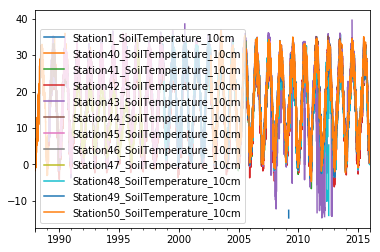

In [53]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SoilTemperature2 = copy.deepcopy(df)
SoilTemperature2.plot()
SoilTemperature2.head(2)

### 13. Isotope

### All result

In [54]:
### not including soil moisture
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity, 
                    WindDirection,WindSpeed,VaporPressure,
                    SoilTemperature1,SoilTemperature2],
                    axis=1,
                    join='outer')
result.index.rename('DateTime',inplace = True)
result.head()

PECOS_Discharge  RAYADO_Discharge  Station1_Precipitation  \
DateTime                                                                
1988-01-01         934.4544          45.30688                     NaN   
1988-01-02         736.2368          45.30688                     NaN   
1988-01-03         679.6032          45.30688                     NaN   
1988-01-04         679.6032          48.13856                     NaN   
1988-01-05         821.1872          48.13856                     NaN   

            Station40_Precipitation  Station41_Precipitation  \
DateTime                                                       
1988-01-01                      0.0                      NaN   
1988-01-02                      0.0                      NaN   
1988-01-03                      0.0                      NaN   
1988-01-04                      0.0                      NaN   
1988-01-05                      0.0                      NaN   

            Station42_Precipitation  Station43_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   
1988-01-04                      NaN                      NaN   
1988-01-05                      NaN                      NaN   

            Station44_Precipitation  Station45_Precipitation  \
DateTime                                                       
1988-01-01                      NaN                      NaN   
1988-01-02                      NaN                      NaN   
1988-01-03                      NaN                      NaN   
1988-01-04                      NaN                      NaN   
1988-01-05                      NaN                      NaN   

            Station46_Precipitation  ...  Station41_SoilTemperature_10cm  \
DateTime                             ...                                   
1988-01-01                      NaN  ...                             NaN   
1988-01-02                      NaN  ...                             NaN   
1988-01-03                      NaN  ...                             NaN   
1988-01-04                      NaN  ...                             NaN   
1988-01-05                      NaN  ...                             NaN   

            Station42_SoilTemperature_10cm  Station43_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   
1988-01-04                             NaN                             NaN   
1988-01-05                             NaN                             NaN   

            Station44_SoilTemperature_10cm  Station45_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   
1988-01-04                             NaN                             NaN   
1988-01-05                             NaN                             NaN   

            Station46_SoilTemperature_10cm  Station47_SoilTemperature_10cm  \
DateTime                                                                     
1988-01-01                             NaN                             NaN   
1988-01-02                             NaN                             NaN   
1988-01-03                             NaN                             NaN   
1988-01-04                             NaN                             NaN   
1988-01-05                             NaN                

In [55]:
result.tail()

PECOS_Discharge  RAYADO_Discharge  Station1_Precipitation  \
DateTime                                                                
2017-12-27        634.29632               NaN                     NaN   
2017-12-28        441.74208               NaN                     NaN   
2017-12-29        481.38560               NaN                     NaN   
2017-12-30        574.83104               NaN                     NaN   
2017-12-31        668.27648               NaN                     NaN   

            Station40_Precipitation  Station41_Precipitation  \
DateTime                                                       
2017-12-27                      NaN                      NaN   
2017-12-28                      NaN                      NaN   
2017-12-29                      NaN                      NaN   
2017-12-30                      NaN                      NaN   
2017-12-31                      NaN                      NaN   

            Station42_Precipitation  Station43_Precipitation  \
DateTime                                                       
2017-12-27                      NaN                      NaN   
2017-12-28                      NaN                      NaN   
2017-12-29                      NaN                      NaN   
2017-12-30                      NaN                      NaN   
2017-12-31                      NaN                      NaN   

            Station44_Precipitation  Station45_Precipitation  \
DateTime                                                       
2017-12-27                      NaN                      NaN   
2017-12-28                      NaN                      NaN   
2017-12-29                      NaN                      NaN   
2017-12-30                      NaN                      NaN   
2017-12-31                      NaN                      NaN   

            Station46_Precipitation  ...  Station41_SoilTemperature_10cm  \
DateTime                             ...                                   
2017-12-27                      NaN  ...                             NaN   
2017-12-28                      NaN  ...                             NaN   
2017-12-29                      NaN  ...                             NaN   
2017-12-30                      NaN  ...                             NaN   
2017-12-31                      NaN  ...                             NaN   

            Station42_SoilTemperature_10cm  Station43_SoilTemperature_10cm  \
DateTime                                                                     
2017-12-27                             NaN                             NaN   
2017-12-28                             NaN                             NaN   
2017-12-29                             NaN                             NaN   
2017-12-30                             NaN                             NaN   
2017-12-31                             NaN                             NaN   

            Station44_SoilTemperature_10cm  Station45_SoilTemperature_10cm  \
DateTime                                                                     
2017-12-27                             NaN                             NaN   
2017-12-28                             NaN                             NaN   
2017-12-29                             NaN                             NaN   
2017-12-30                             NaN                             NaN   
2017-12-31                             NaN                             NaN   

            Station46_SoilTemperature_10cm  Station47_SoilTemperature_10cm  \
DateTime                                                                     
2017-12-27                             NaN                             NaN   
2017-12-28                             NaN                             NaN   
2017-12-29                             NaN                             NaN   
2017-12-30                             NaN                             NaN   
2017-12-31                             NaN                

In [56]:
result.to_csv('1_Sevilleta_Download_Aggregation_Daily.csv', sep=',')

In [57]:
result.columns

Index(['PECOS_Discharge', 'RAYADO_Discharge', 'Station1_Precipitation',
       'Station40_Precipitation', 'Station41_Precipitation',
       'Station42_Precipitation', 'Station43_Precipitation',
       'Station44_Precipitation', 'Station45_Precipitation',
       'Station46_Precipitation',
       ...
       'Station41_SoilTemperature_10cm', 'Station42_SoilTemperature_10cm',
       'Station43_SoilTemperature_10cm', 'Station44_SoilTemperature_10cm',
       'Station45_SoilTemperature_10cm', 'Station46_SoilTemperature_10cm',
       'Station47_SoilTemperature_10cm', 'Station48_SoilTemperature_10cm',
       'Station49_SoilTemperature_10cm', 'Station50_SoilTemperature_10cm'],
      dtype='object', length=110)